# A simple example on how to learn a representation on the Nine Rooms environment

In [1]:
# To supress old gym deprecation warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', message='Parameters to load are deprecated.*')

import numpy as np
from utils import collect_trajectories, representation_score, wandb_plot
from model import SoftClusterNetwork
from torch import optim
import torch
import matplotlib.pyplot as plt

In [2]:
config = {
    "seed": 0,
    "env": "MiniGrid-NineRoomsDet-v0",
    "load_data": False,
    "p_random_action": 0,
    "max_len_episode": 100,
    "pos_or_image": "image",
    "n_episodes_env": 1000,
    "n_abstract_states": 9,
    "width": 19,
    "height": 19,
    "lr": 1e-4,
    "epochs": 1600,
    "batch_size": 32,
    "wl1": 1,
    "wl2": 0.4,
    "wl3": 0.1
}

In [3]:
# First let's collect some random trajectory data
memory, trajectories_dataset, print_states, annotations = collect_trajectories(config)


In [4]:
# set seed
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# # # Training the network
network = SoftClusterNetwork(config["n_abstract_states"], config["width"], config["height"])
optimizer = optim.Adam(network.parameters(), lr=config["lr"])


Epoch 0, Loss: (-0.6022366285324097, 0.07183109223842621, -2.194467067718506, 2.0371904373168945)
Error: 305.5759437460958, Squared Error: 420.672012095573, Abs Error: 442.8053098767996


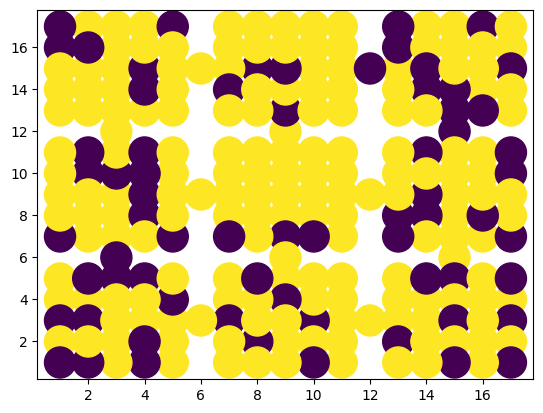

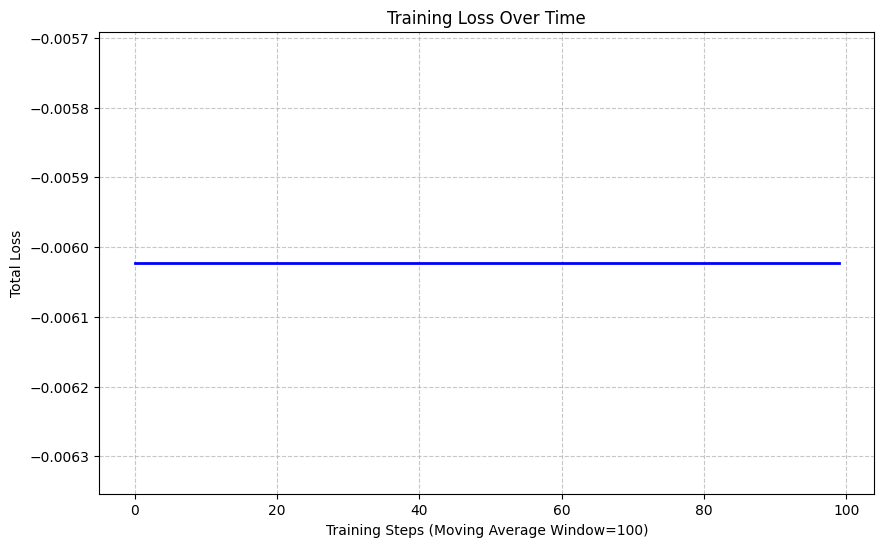

Epoch 100, Loss: (-0.7931329607963562, 0.027687665075063705, -2.175058603286743, 0.49202826619148254)
Error: 170.35335089770595, Squared Error: 209.7246928794316, Abs Error: 253.23330488539068


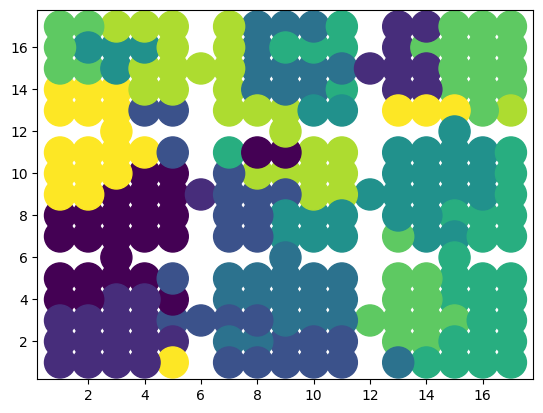

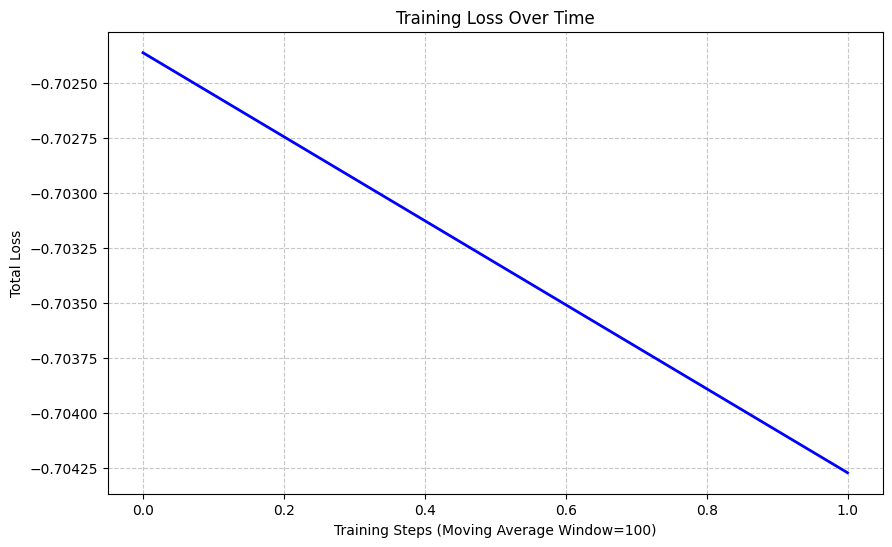

Epoch 200, Loss: (-0.7986995577812195, 0.029322288930416107, -2.165200710296631, 0.3805845379829407)
Error: 135.00898336597777, Squared Error: 169.8026596530704, Abs Error: 197.79529560971423


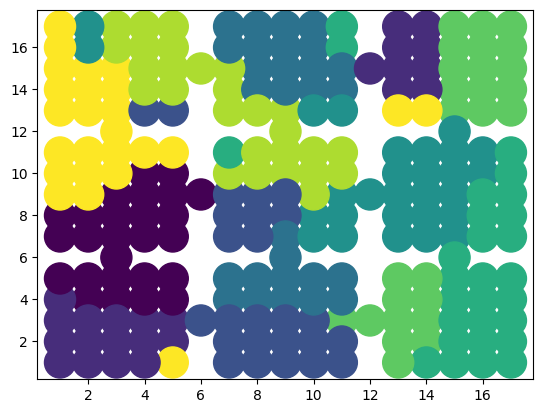

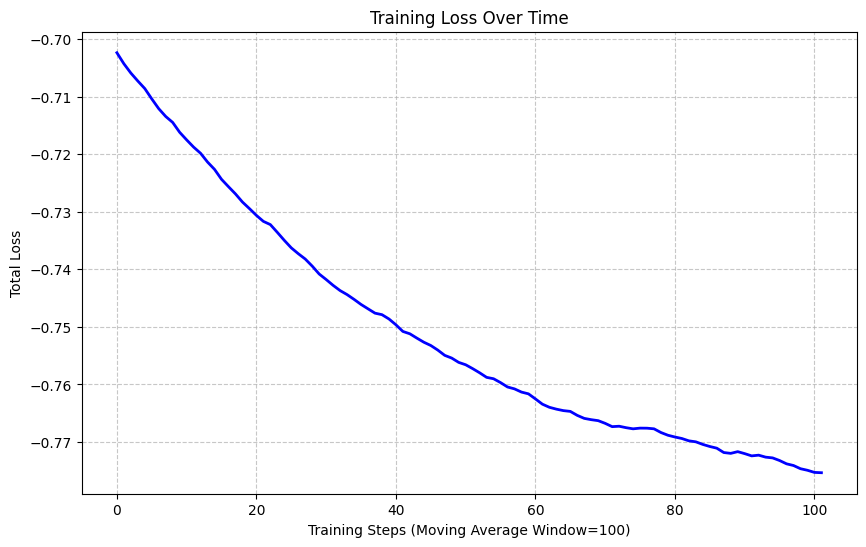

Epoch 300, Loss: (-0.8111269474029541, 0.020715663209557533, -2.1344761848449707, 0.21947862207889557)
Error: 148.26447275238834, Squared Error: 195.927207682899, Abs Error: 213.44007778773084


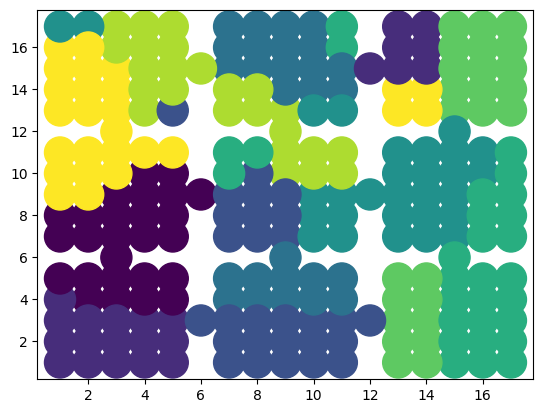

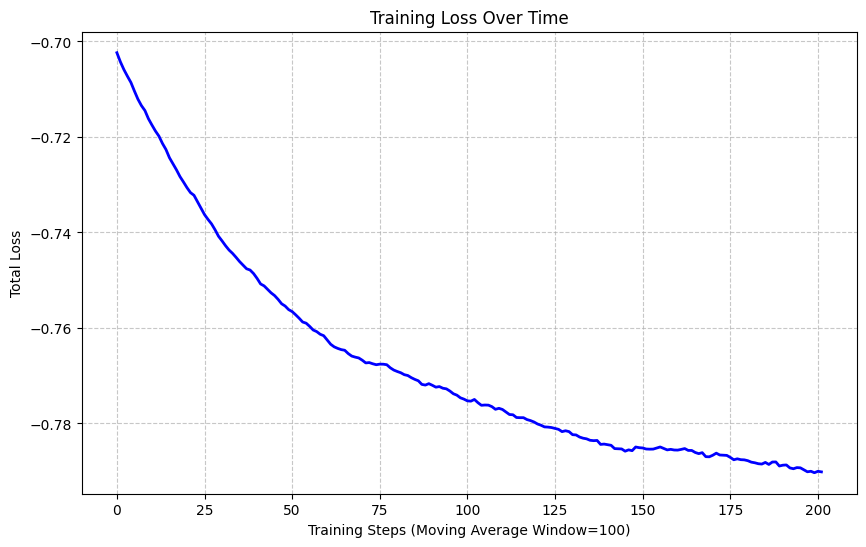

Epoch 400, Loss: (-0.8201389312744141, 0.019441500306129456, -2.1483845710754395, 0.1977345198392868)
Error: 142.53115836455646, Squared Error: 188.50210111241253, Abs Error: 204.1465427352523


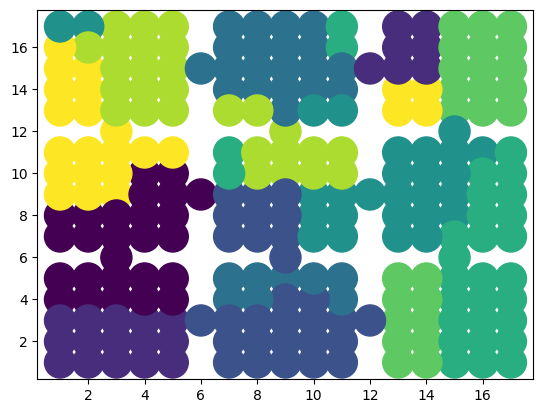

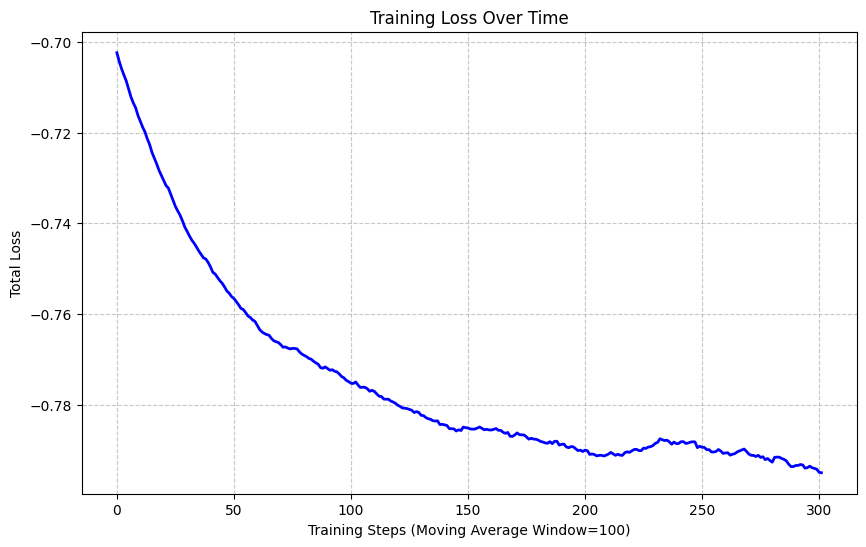

Epoch 500, Loss: (-0.8207228779792786, 0.009428726509213448, -2.1227664947509766, 0.18955005705356598)
Error: 109.79414959876554, Squared Error: 140.50189316193502, Abs Error: 157.74668730886333


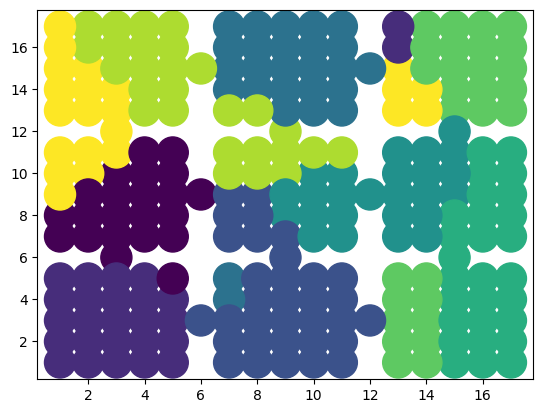

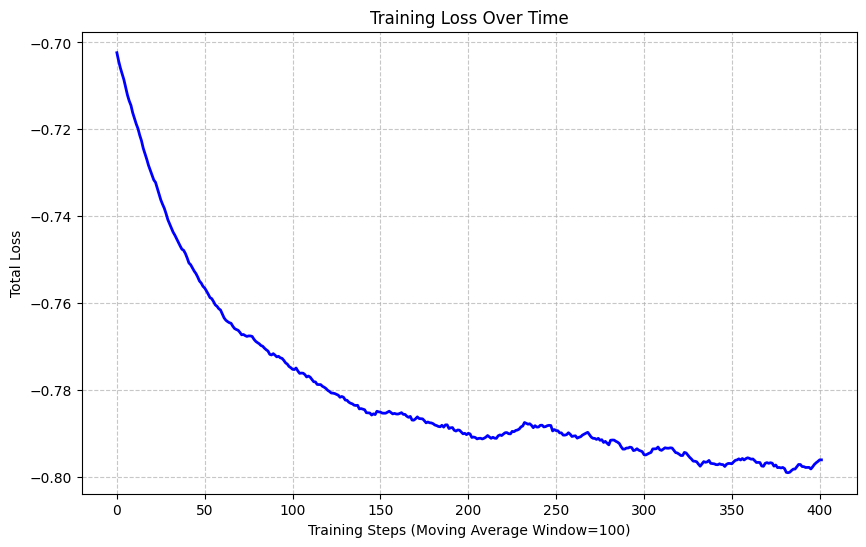

Epoch 600, Loss: (-0.8084266781806946, 0.02523329108953476, -2.140657424926758, 0.22603020071983337)
Error: 99.36860555626922, Squared Error: 129.047968352024, Abs Error: 142.21967670211598


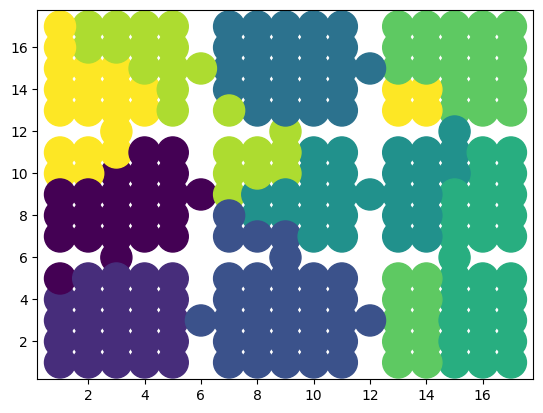

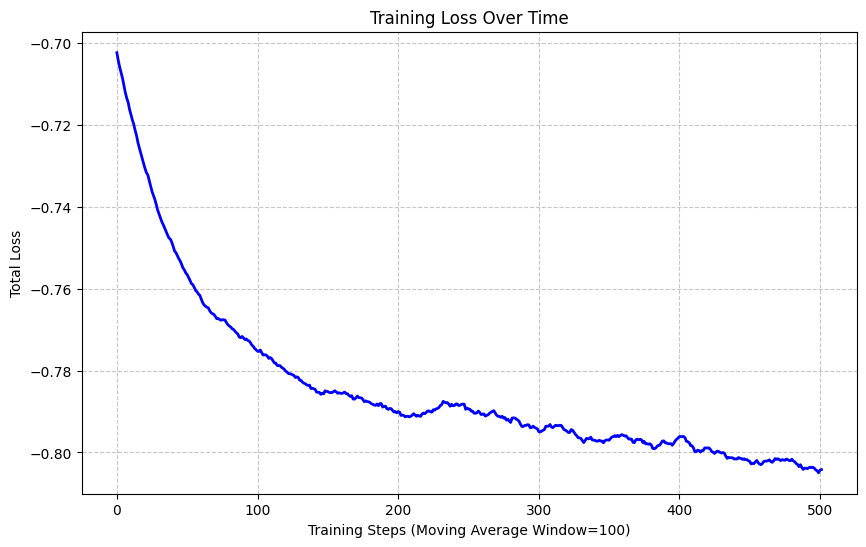

Epoch 700, Loss: (-0.8240101933479309, 0.013439547270536423, -2.1345150470733643, 0.16356289386749268)
Error: 90.56030307618163, Squared Error: 118.32585791425494, Abs Error: 129.65819034839296


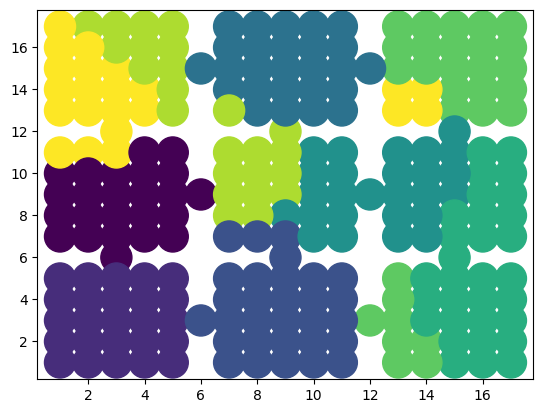

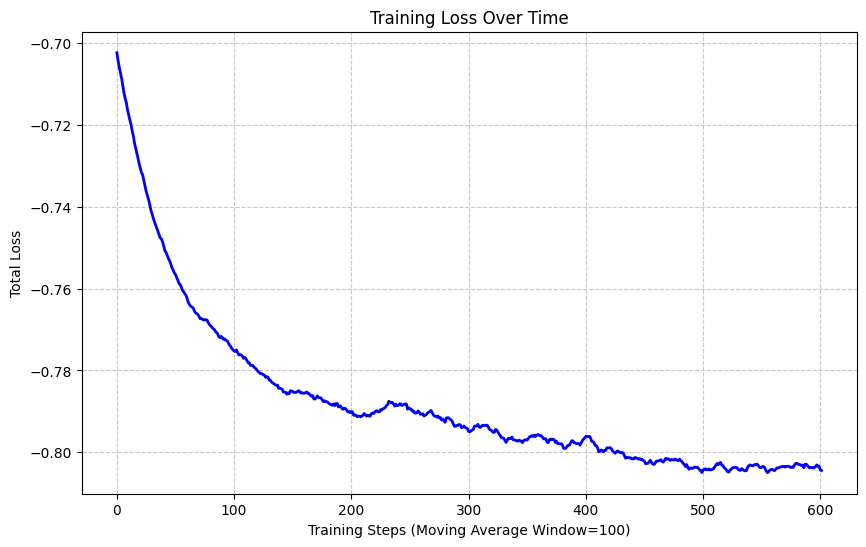

Epoch 800, Loss: (-0.8161496520042419, 0.010289210826158524, -2.099742889404297, 0.13458293676376343)
Error: 89.20525634471822, Squared Error: 119.35961876639654, Abs Error: 126.90773708660345


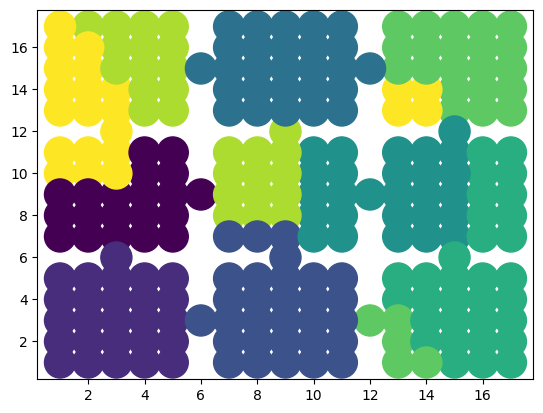

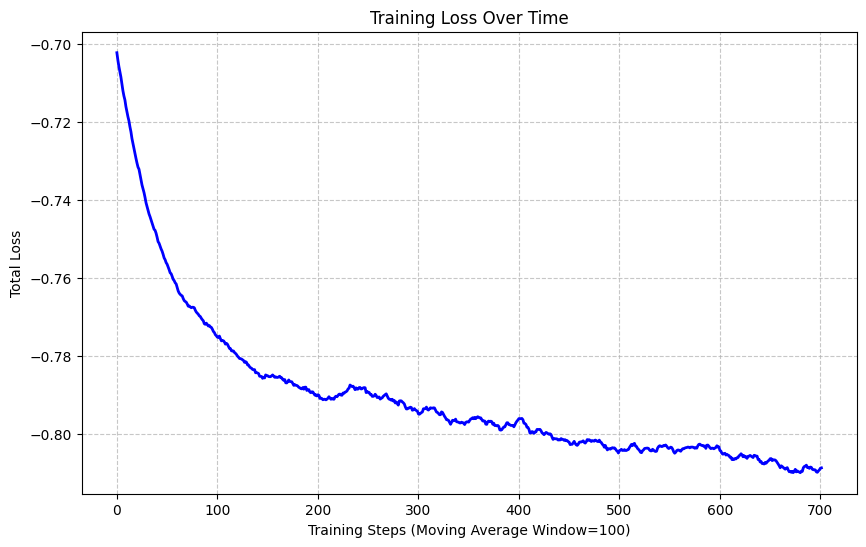

Epoch 900, Loss: (-0.8059284090995789, 0.011539509519934654, -2.0716769695281982, 0.11202891170978546)
Error: 83.21347447875132, Squared Error: 108.31561525544873, Abs Error: 118.50082075129103


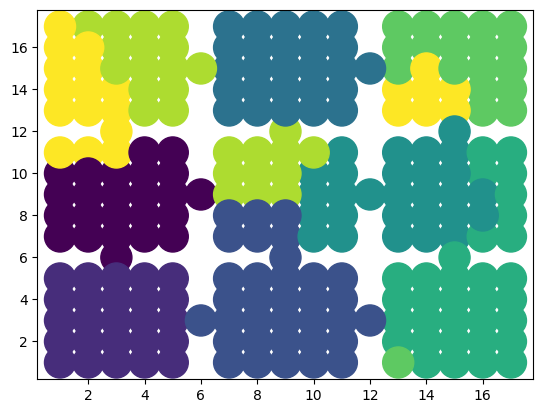

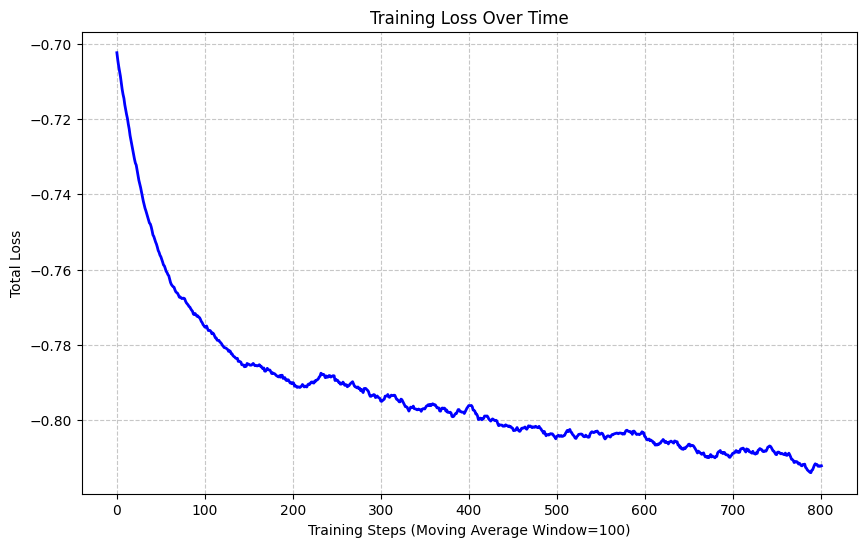

Epoch 1000, Loss: (-0.8108554482460022, 0.007773468736559153, -2.0764288902282715, 0.1194269210100174)
Error: 54.40914742797171, Squared Error: 67.27619673692128, Abs Error: 77.67045067593608


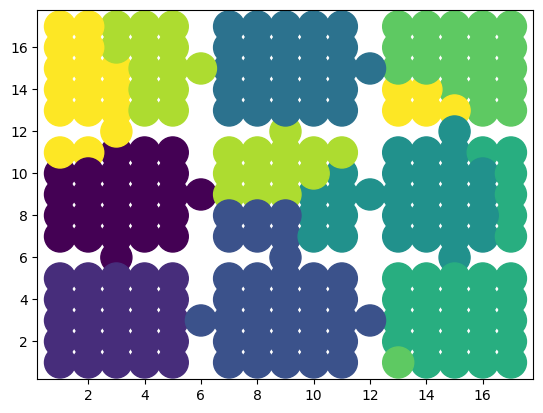

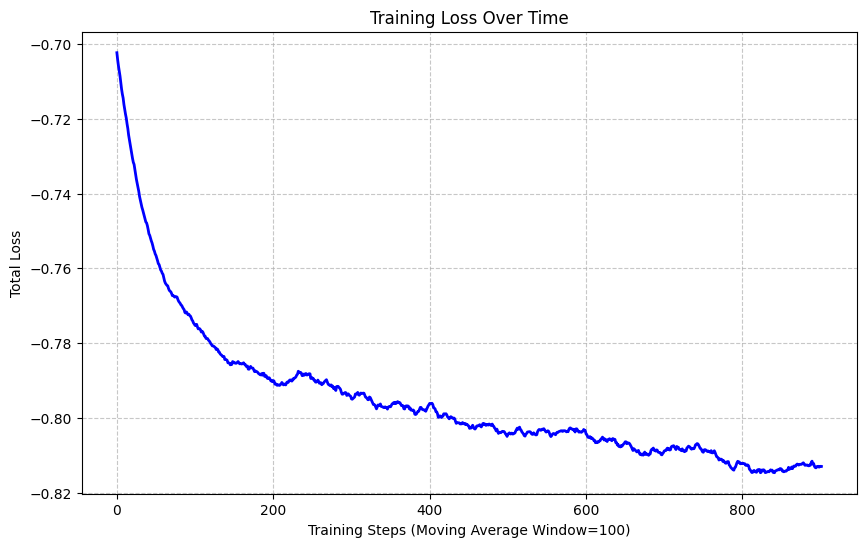

Epoch 1100, Loss: (-0.8052749633789062, 0.009630057960748672, -2.0755276679992676, 0.15306052565574646)
Error: 33.54078946746667, Squared Error: 36.176648549007034, Abs Error: 48.17874252780143


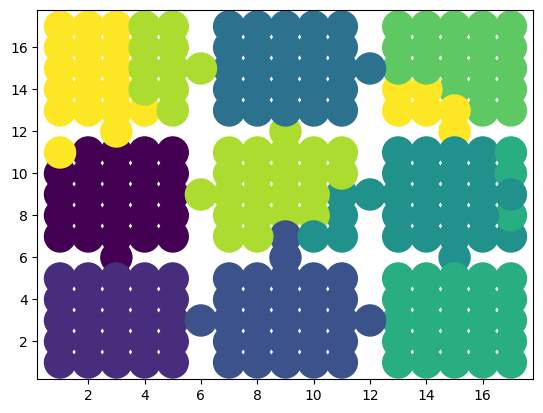

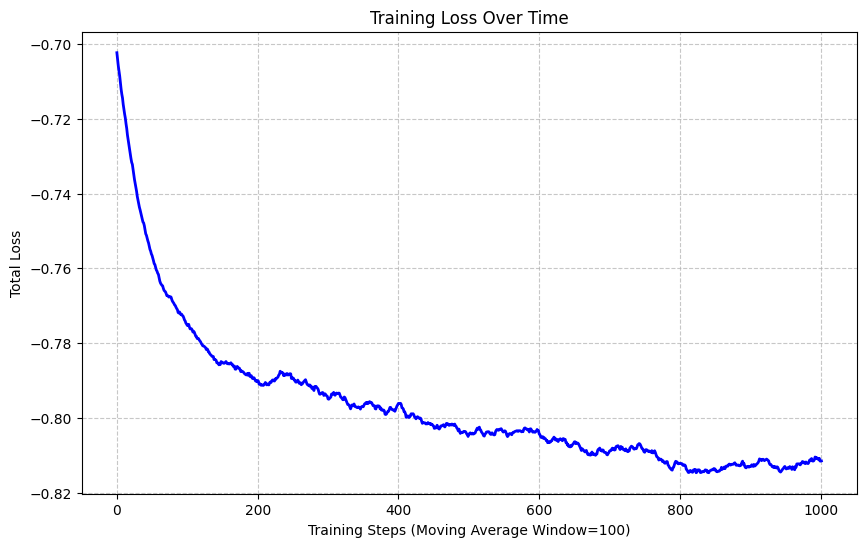

Epoch 1200, Loss: (-0.8229543566703796, 0.018823668360710144, -2.1365866661071777, 0.12856635451316833)
Error: 26.825543577687494, Squared Error: 29.12527389503128, Abs Error: 38.474998854834666


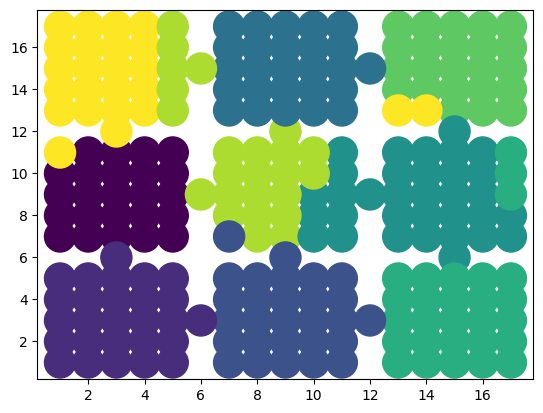

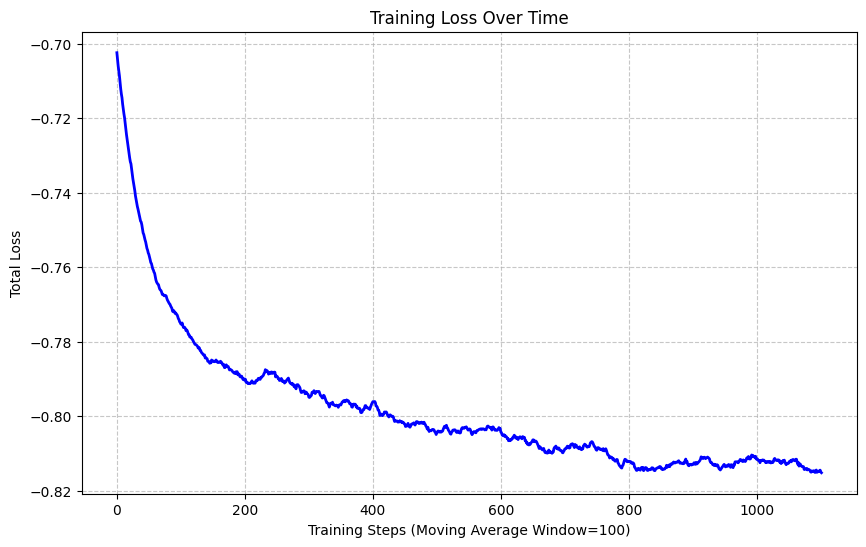

Epoch 1300, Loss: (-0.8070749044418335, 0.009498050436377525, -2.0734505653381348, 0.12807223200798035)
Error: 24.679850688639526, Squared Error: 27.973599970269515, Abs Error: 35.217942604702785


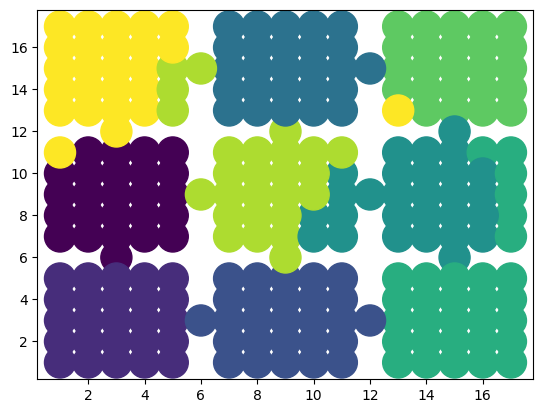

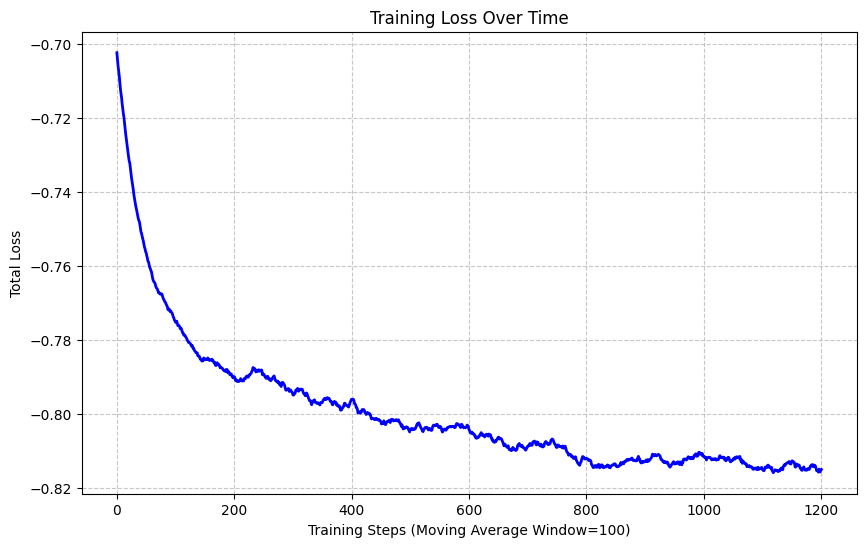

Epoch 1400, Loss: (-0.8377853035926819, 0.0024470253847539425, -2.117724895477295, 0.06857635080814362)
Error: 3.9884433208226526, Squared Error: 2.281596210855183, Abs Error: 5.863062745720526


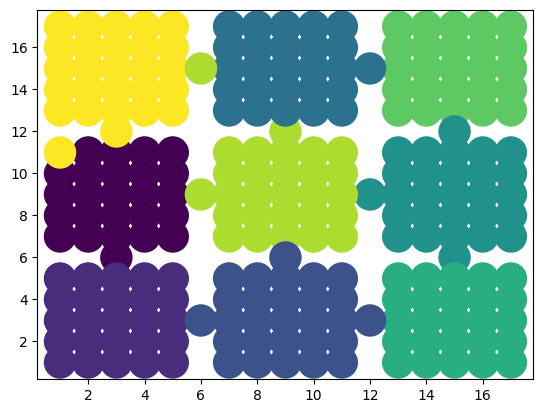

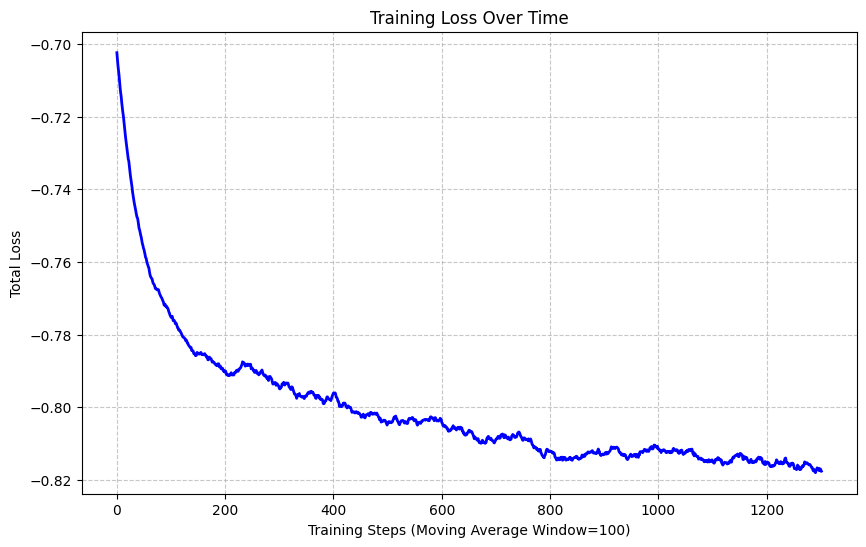

Epoch 1500, Loss: (-0.791814923286438, 0.008228467777371407, -2.016782283782959, 0.06669522821903229)
Error: 1.2109752420125617, Squared Error: 0.21991218564401063, Abs Error: 1.8468945330405404


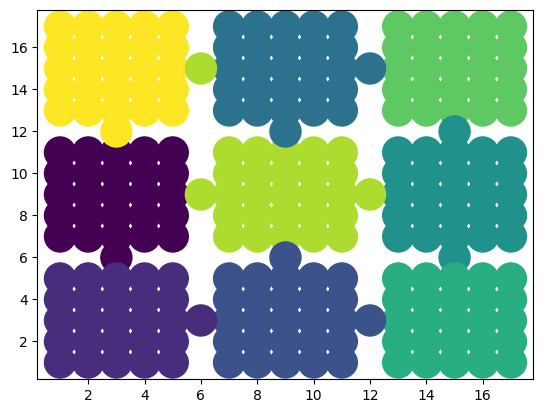

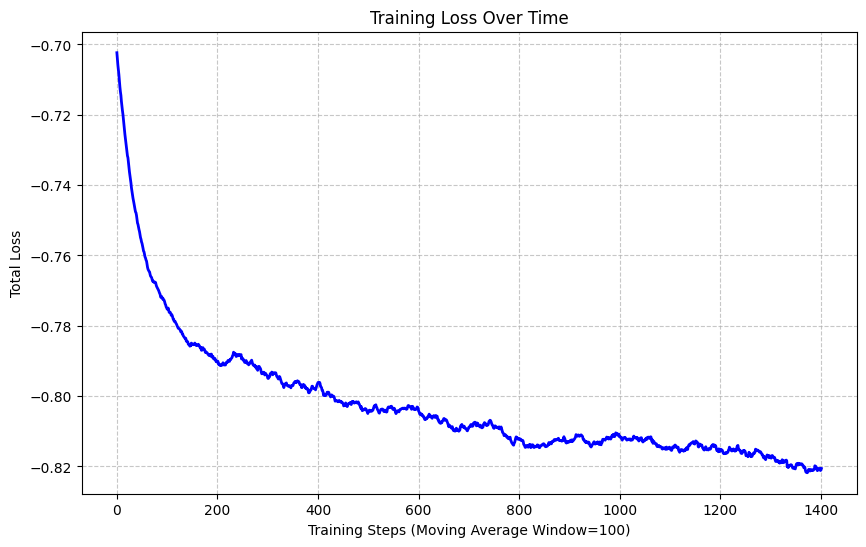

In [5]:
losses = []
for i in range(config["epochs"]):
    network.train()
    idx, batch_x1, batch_x2, b_is_weights = memory.sample(config["batch_size"])
    x1 = torch.stack(batch_x1)
    x2 = torch.stack(batch_x2)
    z1 = network.pred(x1, 1)
    z2 = network.pred(x2, 1)
    compression_loss = ((-(z1 * z2.log())).sum(axis=1)).mean(axis=0)
    compression_loss = compression_loss / config["batch_size"]
    entropy_loss = (z1.mean(dim=0) * (z1.mean(dim=0).log())).sum()
    det_entropy_loss = (- (z1 * z1.log()).sum(dim=1)).mean()
    loss = config["wl1"] * compression_loss + config["wl2"] * entropy_loss + config["wl3"] * det_entropy_loss
    losses.append(loss.item())

    if i % 100 == 0:
        print(f"Epoch {i}, Loss: {loss.item(), compression_loss.item(), entropy_loss.item(), det_entropy_loss.item()}")
        error, squared_error, abs_error = representation_score(config, network.eval())
        print(f"Error: {error}, Squared Error: {squared_error}, Abs Error: {abs_error}")
        fig = wandb_plot(print_states, annotations, network.eval(), d=2)
        # Draw figure on canvas
        fig.canvas.draw()
        plt.show()

        # Create a new figure for losses
        plt.figure(figsize=(10, 6))
        # moving windows on the losses
        losses_to_plot = np.convolve(losses, np.ones(100)/100, mode='valid')
        # plot the losses graph with labels and title
        plt.plot(losses_to_plot, color='blue', linewidth=2)
        plt.xlabel('Training Steps (Moving Average Window=100)')
        plt.ylabel('Total Loss')
        plt.title('Training Loss Over Time')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    optimizer.zero_grad()
    loss.backward()
    # Replace gradient clamping with norm clipping
    torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=0.1)
    optimizer.step()
